In [384]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import PolynomialFeatures
import math
import matplotlib
from sklearn.utils import shuffle

# Load the data
mlr_data = pd.read_csv('')
mlr_data = shuffle(mlr_data,random_state=1)
# Display the first few rows to understand the structure
print(mlr_data.head())

      well_id replicate_number assay_type assay_number treatment_1  \
13046     105               R2    CD8 MLR        MLR85     GEN1053   
15849     160               R1    CD8 MLR        MLR85     GEN1053   
10583      55               R2    CD8 MLR        MLR85     GEN1053   
13704     119               R1    CD8 MLR        MLR85    CD3/CD28   
20501     247               R2    CD8 MLR        MLR85        IgG4   

       concentration_1    treatment_2  concentration_2 donor_1_type  \
13046            0.000  Pembrolizumab             0.01     DC Donor   
15849            0.001  Pembrolizumab             1.00     DC Donor   
10583            1.000  Pembrolizumab             0.10     DC Donor   
13704              NaN            NaN              NaN     DC Donor   
20501            1.000            NaN              NaN     DC Donor   

              donor_1_id  donor_2_type            donor_2_id scientist  \
13046  LS 24 18861 58355  T cell Donor  LS 11 69613B CC00489      NACH   
1584

/var/folders/xq/0rbx0mys6297mxympm5jbqw80000gn/T/ipykernel_26526/3697649020.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(mlr_data[treatment_col], shade=True)


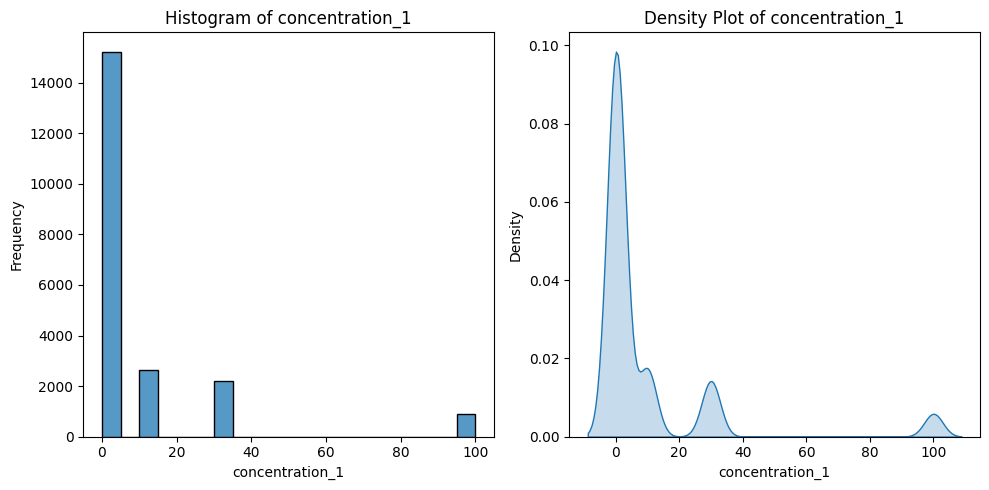

/var/folders/xq/0rbx0mys6297mxympm5jbqw80000gn/T/ipykernel_26526/3697649020.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(mlr_data[treatment_col], shade=True)


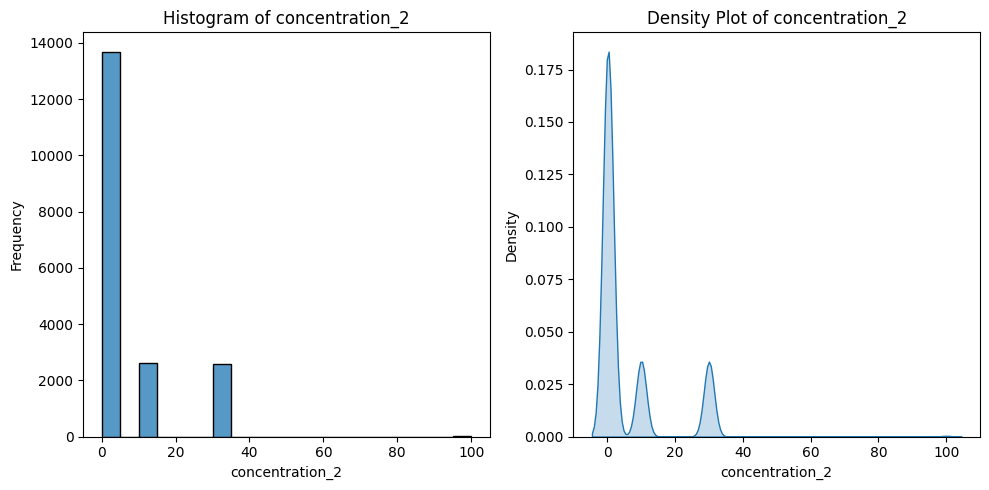

In [385]:
# Assuming the data has columns for treatments and cytokines, replace these column names with actual ones
treatment1_col = 'concentration_1'
treatment2_col = 'concentration_2'

for treatment_col in [treatment1_col, treatment2_col]:
    plt.figure(figsize=(10, 5))
    
    # Histogram plot
    plt.subplot(1, 2, 1)
    sns.histplot(mlr_data[treatment_col], kde=False, bins=20)
    plt.title(f'Histogram of {treatment_col}')
    plt.xlabel(treatment_col)
    plt.ylabel('Frequency')

    # Density plot
    plt.subplot(1, 2, 2)
    sns.kdeplot(mlr_data[treatment_col], shade=True)
    plt.title(f'Density Plot of {treatment_col}')
    plt.xlabel(treatment_col)
    plt.ylabel('Density')
    
    plt.tight_layout()
    plt.show()

In [386]:
# Loop through each unique analyte and plot, skipping if insufficient data
unique_analytes = mlr_data['analyte'].unique()

In [387]:
"""
Part of this code is adapted from https://matplotlib.org/stable/plot_types/basic/scatter_plot.html#sphx-glr-plot-types-basic-scatter-plot-py
"""

def plot_1d(treatment, analyte):
    # data_1 = mlr_data.loc[ (mlr_data["treatment_1"]==treatment) &
    #                     (mlr_data["concentration_2"]==0) &
    #                     (mlr_data["analyte"]==analyte) &
    #                     (mlr_data["donor_1_id"]=="LS 24 18861 58355") &
    #                     (mlr_data["donor_2_id"]=="LS 11 71012 CC00481")
    #                     ]
    # data_2 = mlr_data.loc[ ((mlr_data["treatment_2"]==treatment) &
    #                     (mlr_data["concentration_1"]==0)) & 
    #                     (mlr_data["analyte"]==analyte) &
    #                     (mlr_data["donor_1_id"]=="LS 24 18861 58355") &
    #                     (mlr_data["donor_2_id"]=="LS 11 71012 CC00481")
    #                     ]
    data_1 = mlr_data.loc[ (mlr_data["treatment_1"]==treatment) &
                        (mlr_data["concentration_2"]==0) &
                        (mlr_data["analyte"]==analyte)
                        ]
    data_2 = mlr_data.loc[ ((mlr_data["treatment_2"]==treatment) &
                        (mlr_data["concentration_1"]==0)) & 
                        (mlr_data["analyte"]==analyte)
                        ]
    if data_1.empty & data_2.empty:
        return
    
    if data_1.empty:
        X = data_2.copy()["concentration_2"]
        y = data_2.copy()["analyte_value"]
        
    else:
        X = data_1.copy()["concentration_1"]
        y = data_1.copy()["analyte_value"]
    print()
    corr = np.corrcoef(X,y)[0][1]
    if  corr < 0.5:
        return
    fig, ax = plt.subplots()
    ax.scatter(X, y)
    ax.set_title("Treatment: " + str(treatment) + "   Analyte: " + str(analyte)+"    Correlation: " + str(corr))
    plt.show()

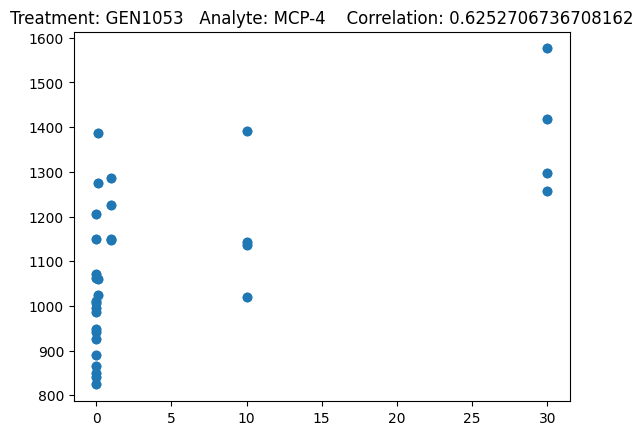

/Users/ericdai/Library/Python/3.9/lib/python/site-packages/numpy/lib/_function_base_impl.py:2914: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/ericdai/Library/Python/3.9/lib/python/site-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/ericdai/Library/Python/3.9/lib/python/site-packages/numpy/lib/_function_base_impl.py:2773: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


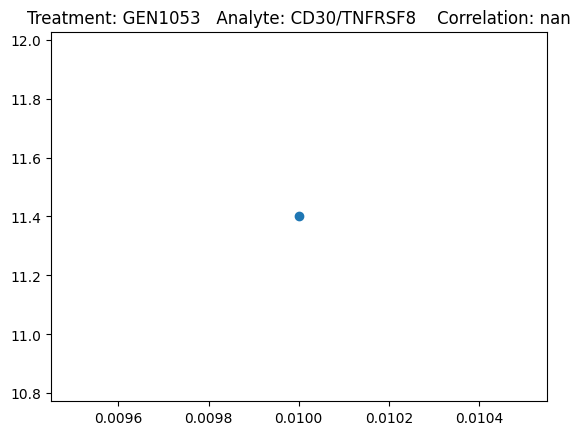

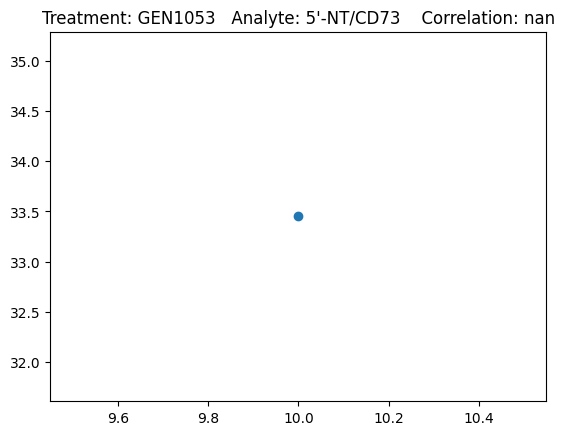

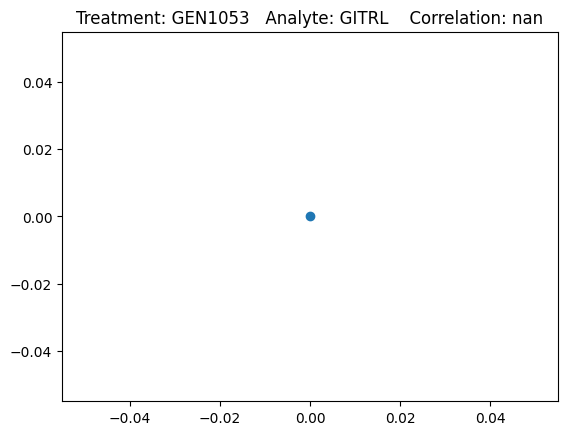

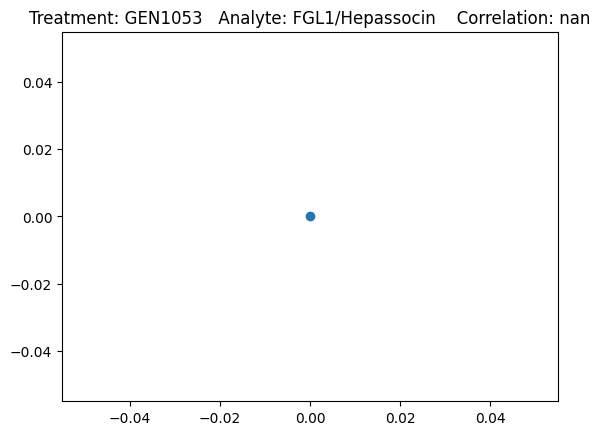

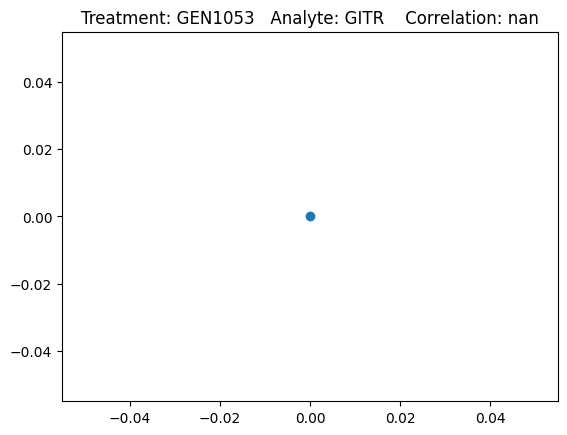

In [388]:
for analyte in unique_analytes:
    # plot_1d("Pembrolizumab","MCP-4")
    plot_1d("GEN1053",analyte)

In [389]:
"""
Method of computation gotten and adapted from 
Taketa, K., & Pogell, B. M. (1965). Allosteric inhibition of rat liver fructose 1, 6-diphosphatase by adenosine 5'-monophosphate. Journal of Biological Chemistry, 240(2), 651-662.
Altszyler, E., Ventura, A. C., Colman-Lerner, A., & Chernomoretz, A. (2017). Ultrasensitivity in signaling cascades revisited: Linking local and global ultrasensitivity estimations. PloS one, 12(6), e0180083. https://doi.org/10.1371/journal.pone.0180083
Inspiration of designing this method is also from Rob Mulla on https://www.youtube.com/watch?v=QpzMWQvxXWk
"""
# Method to see if we can compute the Hill coefficient
def Hill_coef_computable(data,X,y):
    y_max = data[y].max()
    y_min = data[y].min()
    y_range = y_max - y_min
    X_max = data.loc[(data[y]>0.9 * y_range + y_min) & (data[y]< y_max), X]
    X_min = data.loc[(data[y]<0.1 * y_range + y_min) & (data[y]> y_min), X]
    if X_max.size == 0:
        return False
    if X_min.size == 0:
        return False
    return True


In [390]:
"""
Method of computation gotten and adapted from 
Taketa, K., & Pogell, B. M. (1965). Allosteric inhibition of rat liver fructose 1, 6-diphosphatase by adenosine 5'-monophosphate. Journal of Biological Chemistry, 240(2), 651-662.
Altszyler, E., Ventura, A. C., Colman-Lerner, A., & Chernomoretz, A. (2017). Ultrasensitivity in signaling cascades revisited: Linking local and global ultrasensitivity estimations. PloS one, 12(6), e0180083. https://doi.org/10.1371/journal.pone.0180083
"""
# Method to compute the hill coefficient
def Hill_coef(data,X,y):
    y_max = data[y].max()
    y_min = data[y].min()
    y_range = y_max - y_min
    X_90 = data.loc[data[y]>0.9 * y_range + y_min, X].min()
    X_10 = data.loc[data[y]<0.1 * y_range + y_min, X].max()
    quotient = X_90/X_10
    coef = math.log10(81)/math.log10(quotient)
    return coef

In [391]:
# data = mlr_data.loc[
#         (mlr_data["treatment_1"] == "GEN1056") & 
#         (mlr_data["treatment_2"] == "GEN1053") & 
#         (mlr_data["analyte"] == "IL-10"), 
#         ["concentration_1", "concentration_2", "analyte_value"]
#     ]
# data_1 = data.loc[data["concentration_2"]==0]
# # print(data_1)
# print(Hill_coef(data_1,"concentration_1","analyte_value"))
# Hill_coef_computable(data_1,"concentration_1","analyte_value")

In [392]:
"""
The design of this method is inspired by Rob Mulla on https://www.youtube.com/watch?v=QpzMWQvxXWk
"""
def plotable(treatment_1, treatment_2, analyte):
    data = mlr_data.loc[
        (mlr_data["treatment_1"] == treatment_1) & 
        (mlr_data["treatment_2"] == treatment_2) & 
        (mlr_data["analyte"] == analyte), 
        ["concentration_1", "concentration_2", "analyte_value"]
    ]
    data_2 = data.loc[data["concentration_1"]==0]
    data_1 = data.loc[data["concentration_2"]==0]
    # Check if the data has less than 30 samples
    if data.size<30:
        return False
    return True


In [393]:
"""
Part of code in this mehtod is adapted from https://matplotlib.org/stable/plot_types/3D/scatter3d_simple.html#sphx-glr-plot-types-3d-scatter3d-simple-py
and helped by other examples from the official website of matplotlib: https://matplotlib.org/stable/
"""
def plot(treatment_1, treatment_2, analyte):
    data = mlr_data.loc[
        (mlr_data["treatment_1"] == treatment_1) & 
        (mlr_data["treatment_2"] == treatment_2) & 
        (mlr_data["analyte"] == analyte), 
        ["concentration_1", "concentration_2", "analyte_value"]
    ]
    
    # Check if the data is empty
    if not plotable(treatment_1, treatment_2, analyte):
        print(f"Skipping {analyte} due to insufficient data.")
        return 
    
    xs = data["concentration_1"].values
    ys = data["concentration_2"].values
    zs = data["analyte_value"].values
    X = data[["concentration_1", "concentration_2"]]
    y = zs

    # Fit a linear regression model
    model = LinearRegression()
    model.fit(data[["concentration_1", "concentration_2"]], zs)

    # Create a grid for plotting the regression plane
    x_pred = np.linspace(xs.min(), xs.max(), 30)
    y_pred = np.linspace(ys.min(), ys.max(), 30)
    x_pred, y_pred = np.meshgrid(x_pred, y_pred)
    z_pred = model.predict(np.c_[x_pred.ravel(), y_pred.ravel()]).reshape(x_pred.shape)
    
    # Compute the mean of cross validation results of r square
    r_square = -cross_val_score(model, X, y, cv=5, scoring="r2").mean()

    # Plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xs, ys, zs, color='blue', label='Data points')
    ax.plot_surface(x_pred, y_pred, z_pred, color='red', alpha=0.5, rstride=100, cstride=100)
    
    # Adding contour plot
    contour = ax.contourf(x_pred, y_pred, z_pred, zdir='z', offset=zs.min(), cmap='viridis', alpha=0.5)
    fig.colorbar(contour, ax=ax, shrink=0.5, aspect=5)
    
    ax.set_xlabel(treatment_1 + " concentration")
    ax.set_ylabel(treatment_2 + " concentration")
    ax.set_zlabel(analyte + " value")
    ax.set_title(f"3D Surface Plot with Regression Plane and Contours for {analyte}" " r square: " + str(r_square))
    ax.legend()
    plt.show()
    return r_square

In [394]:
"""
Helped by 
https://www.youtube.com/watch?v=3CCkeFShB3U
https://www.youtube.com/watch?v=kE_I-5rxtEA&t=164s
"""

# Computes the r^2 of model fit on specified treatments and analyte and dimension

def r_square(treatment_1, treatment_2, analyte, dimension=1):
    data = mlr_data.loc[
        (mlr_data["treatment_1"] == treatment_1) & 
        (mlr_data["treatment_2"] == treatment_2) & 
        (mlr_data["analyte"] == analyte), 
        ["concentration_1", "concentration_2", "analyte_value"]
    ]
    
    # Check if the data is empty
    if not plotable(treatment_1, treatment_2, analyte):
        return 
    
    X = data[["concentration_1", "concentration_2"]]
    y = data["analyte_value"].values
    if dimension == "interactive":
        X["interaction"] = X["concentration_1"].mul(X["concentration_2"])
    else:
        polynomial = PolynomialFeatures(dimension)
        X = polynomial.fit_transform(X)
    # Fit a linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Compute the mean of cross validation results of r square
    # r_square = -cross_val_score(model, X, y, cv=5, scoring="r2").mean()
    r_square = cross_val_score(model, X, y, cv=5, scoring="r2").mean()
    return r_square
    

In [395]:
# cross_val_mae("GEN1056","GEN1053","IL-10","interactive")

In [396]:
"""
Part of code in this mehtod is adapted from https://matplotlib.org/stable/plot_types/3D/scatter3d_simple.html#sphx-glr-plot-types-3d-scatter3d-simple-py
and helped by other examples from the official website of matplotlib: https://matplotlib.org/stable/
Helped by 
https://www.youtube.com/watch?v=3CCkeFShB3U
https://www.youtube.com/watch?v=kE_I-5rxtEA&t=164s
"""
def poly_plot(treatment_1, treatment_2, analyte, dimension):
    data = mlr_data.loc[
        (mlr_data["treatment_1"] == treatment_1) & 
        (mlr_data["treatment_2"] == treatment_2) & 
        (mlr_data["analyte"] == analyte), 
        ["concentration_1", "concentration_2", "analyte_value"]
    ]
    
    # Check if the data is empty
    if not plotable(treatment_1, treatment_2, analyte):
        print(f"Skipping {analyte} due to insufficient data.")
        return 
    
    xs = data["concentration_1"].values
    ys = data["concentration_2"].values
    zs = data["analyte_value"].values
    X = data[["concentration_1", "concentration_2"]]
    if dimension == "interactive":
        X["interaction"] = X["concentration_1"].mul(X["concentration_2"])
    else:
        polynomial = PolynomialFeatures(dimension)
        X = polynomial.fit_transform(X)
    y = zs

    # Fit a linear regression model
    model = LinearRegression()
    model.fit(xs,ys, zs)

    # Create a grid for plotting the regression plane
    x_pred = np.linspace(xs.min(), xs.max(), 30)
    y_pred = np.linspace(ys.min(), ys.max(), 30)
    x_pred, y_pred = np.meshgrid(x_pred, y_pred)
    z_pred = model.predict(np.c_[x_pred.ravel(), y_pred.ravel()]).reshape(x_pred.shape)
    
    # Compute the mean of cross validation results of r square
    # r_square = -cross_val_score(model, X, y, cv=5, scoring="r2").mean()
    r_square = cross_val_score(model, X, y, cv=5, scoring="r2").mean()

    # Plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xs, ys, zs, color='blue', label='Data points')
    ax.plot_surface(x_pred, y_pred, z_pred, color='red', alpha=0.5, rstride=100, cstride=100)
    
    # Adding contour plot
    contour = ax.contourf(x_pred, y_pred, z_pred, zdir='z', offset=zs.min(), cmap='viridis', alpha=0.5)
    fig.colorbar(contour, ax=ax, shrink=0.5, aspect=5)
    
    ax.set_xlabel(treatment_1 + " concentration")
    ax.set_ylabel(treatment_2 + " concentration")
    ax.set_zlabel(analyte + " value")
    ax.set_title(f"3D Surface Plot with Regression Plane and Contours for {analyte}" " r square: " + str(r_square))
    ax.legend()
    plt.show()
    return r_square

In [397]:
GEN1056_GEN1053_error_table = {}
analytes = []
errors = [[],[],[],[]]
for dimension in range (1,4):
    for analyte in unique_analytes:
        if plotable("GEN1056", "GEN1053", analyte):
            # plot("GEN1056", "GEN1053", analyte)
            if analyte not in analytes:
                analytes.append(analyte)
            errors[dimension-1].append(float(r_square("GEN1056", "GEN1053", analyte, dimension=dimension)))
    GEN1056_GEN1053_error_table["dimension "+str(dimension)+" r square"] = errors[dimension-1]
for analyte in unique_analytes:
    if plotable("GEN1056", "GEN1053", analyte):
        # plot("GEN1053", "Pembrolizumab", analyte)
        errors[3].append(float(r_square("GEN1056", "GEN1053", analyte, dimension="interactive")))
GEN1056_GEN1053_error_table["interaction r square"]=errors[3]
GEN1056_GEN1053_error_table["analyte"]=analytes
GEN1056_GEN1053_error_table = pd.DataFrame(GEN1056_GEN1053_error_table)
GEN1056_GEN1053_error_table["maximum"]=GEN1056_GEN1053_error_table[["dimension 1 r square","dimension 2 r square", "dimension 3 r square", "interaction r square"]].max(axis=1)
GEN1056_GEN1053_error_table["maximum_id"]=GEN1056_GEN1053_error_table[["dimension 1 r square","dimension 2 r square", "dimension 3 r square", "interaction r square"]].idxmax(axis=1)

In [398]:
GEN1053_Pembrolizumab_error_table = {}
analytes = []
errors = [[],[],[],[]]
for dimension in range (1,4):
    for analyte in unique_analytes:
        if plotable("GEN1053", "Pembrolizumab", analyte):
            # plot("GEN1053", "Pembrolizumab", analyte)
            if analyte not in analytes:
                analytes.append(analyte)
            errors[dimension-1].append(float(r_square("GEN1053", "Pembrolizumab", analyte, dimension=dimension)))
    GEN1053_Pembrolizumab_error_table["dimension "+str(dimension)+" r square"] = errors[dimension-1]
for analyte in unique_analytes:
    if plotable("GEN1053", "Pembrolizumab", analyte):
        # plot("GEN1053", "Pembrolizumab", analyte)
        errors[3].append(float(r_square("GEN1053", "Pembrolizumab", analyte, dimension="interactive")))
GEN1053_Pembrolizumab_error_table["interaction r square"]=errors[3]
GEN1053_Pembrolizumab_error_table["analyte"]=analytes
GEN1053_Pembrolizumab_error_table = pd.DataFrame(GEN1053_Pembrolizumab_error_table)
GEN1053_Pembrolizumab_error_table["maximum"]=GEN1053_Pembrolizumab_error_table[["dimension 1 r square","dimension 2 r square", "dimension 3 r square", "interaction r square"]].max(axis=1)
GEN1053_Pembrolizumab_error_table["maximum_id"]=GEN1053_Pembrolizumab_error_table[["dimension 1 r square","dimension 2 r square", "dimension 3 r square", "interaction r square"]].idxmax(axis=1)

In [399]:
GEN1056_GEN1053_error_table = GEN1056_GEN1053_error_table.sort_values(by=['maximum'],ascending=False)
GEN1053_Pembrolizumab_error_table = GEN1053_Pembrolizumab_error_table.sort_values(by=['maximum'],ascending=False)

In [400]:
print(GEN1056_GEN1053_error_table)

    dimension 1 r square  dimension 2 r square  dimension 3 r square  \
8              -0.038192              0.192684              0.580411   
3               0.096811              0.268035              0.570627   
6               0.115844              0.354380              0.557850   
2               0.145886              0.327286              0.539140   
9               0.083787              0.345670              0.516187   
18              0.305723              0.332915              0.405034   
4               0.009717              0.145487              0.369454   
22             -0.011921              0.118346              0.331319   
25              0.044742              0.140435              0.318251   
27              0.049217              0.159372              0.317989   
20              0.005314              0.189885              0.296093   
19              0.094094              0.200201              0.263094   
1              -0.067051              0.058838              0.25

In [401]:
print(GEN1053_Pembrolizumab_error_table)

    dimension 1 r square  dimension 2 r square  dimension 3 r square  \
57              0.839043              0.835145          8.308475e-01   
23              0.826980              0.835720          8.215946e-01   
52              0.540916              0.544941         -8.480365e+00   
47              0.155015              0.111022          6.077287e-02   
28              0.089835              0.145991          1.515819e-01   
..                   ...                   ...                   ...   
56             -0.142126             -0.305438         -4.840891e-01   
33             -0.220540             -0.416101         -3.426156e-01   
42             -0.251682             -0.283768         -4.377312e-01   
58             -1.104188            -11.868750         -1.110951e+03   
55             -2.167804             -7.268932         -1.587624e+07   

    interaction r square       analyte   maximum            maximum_id  
57              0.837266     CD80/B7-1  0.839043  dimension 1 

In [402]:
print(r_square("Pembrolizumab","GEN1053","MCP-4",dimension=1))
print(r_square("Pembrolizumab","GEN1053","MCP-4",dimension="interactive"))

0.20664884284539603
0.2104084556497706
